# Extracting and seqlets from AI-TAC and bpAI-TAC, clustering, and finding enriched motifs

### Find motifs and look at different statistics

(1082, 4, 998) (1082, 10, 4, 998)
Estimated cutoff with p-value 0.001 and z-score 3.2905267314919255 for significance from standard deviation 0.2109440765878542


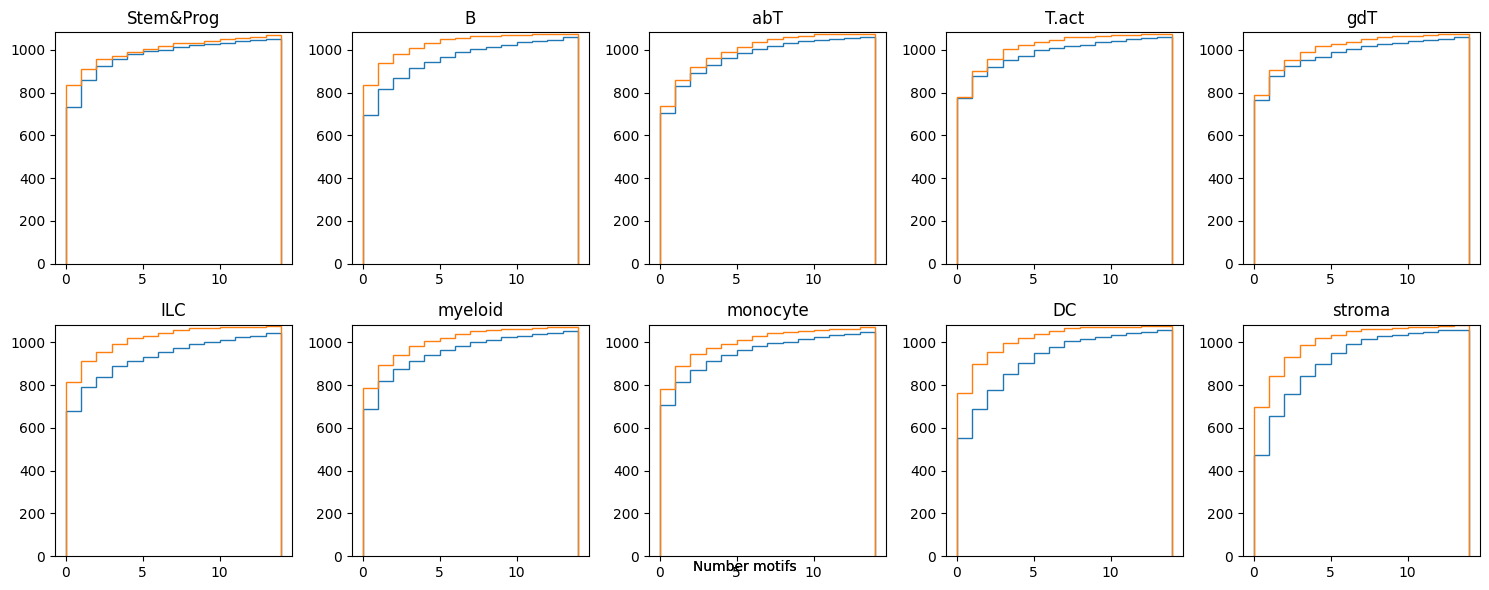

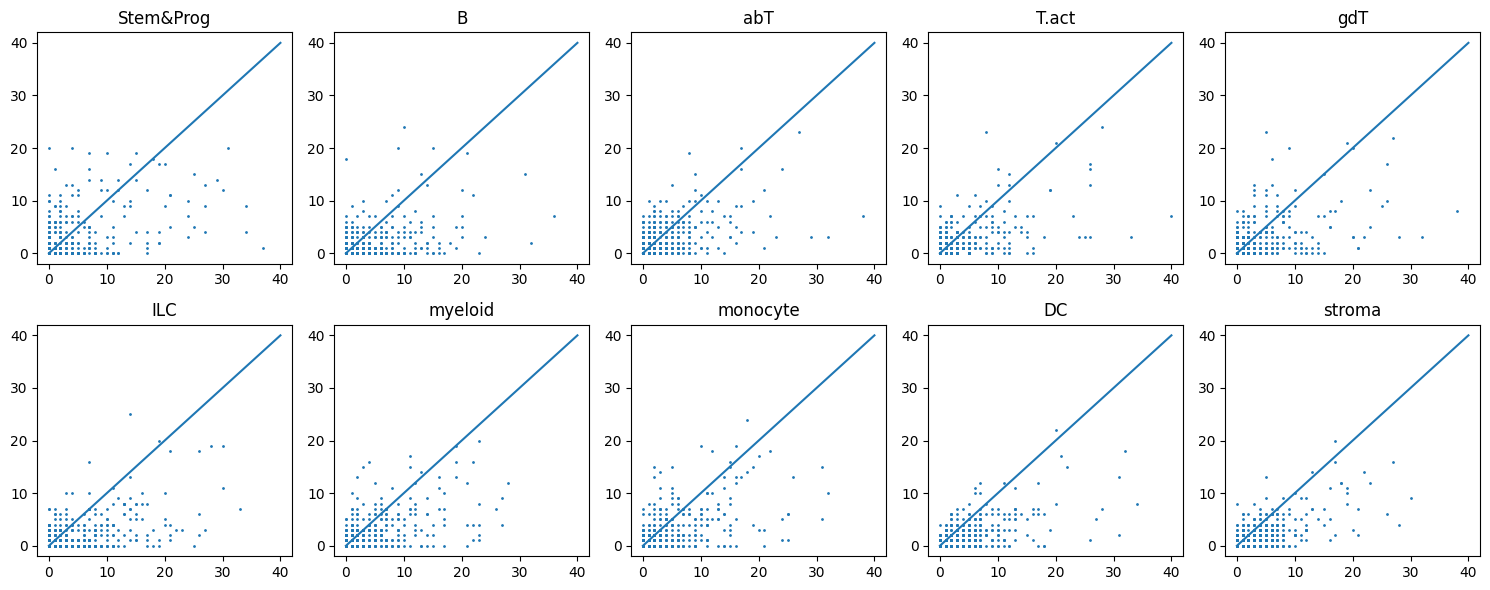

In [2]:
from drg_tools.motif_analysis import find_motifs
import matplotlib.pyplot as plt
import matplotlib.pyplot as pl
import os
import numpy as np
import scipy.stats

dir_path = os.path.expanduser('~/UW/BPAI-TAC/Attributions/') 
file_path = os.path.join(dir_path, 'BP203_200.5_deep_lift_shap_hypothetical_v3_t10_5.11.25.npz')
attfile = np.load(file_path)
region_names, onehot_seq, lineage_names, L0_attributions, L0p5_attributions = attfile['region_names'], attfile['onehot_seq'], attfile['lineage_names'], attfile['L0_attributions'], attfile['L0p5_attributions']

print(onehot_seq.shape, L0_attributions.shape)

# Correct the attributions to be hypothetical attributions
L0_attributions = L0_attributions - np.mean(L0_attributions, axis = (-2), keepdims = True)
L0p5_attributions = L0p5_attributions - np.mean(L0p5_attributions, axis = (-2), keepdims = True)

sigthresh = 0.001 # Significance threshold for attributions
# transform the p-value threshold to a z-score
zthresh = scipy.stats.norm.ppf(1 - sigthresh / 2)
# Determine significance cut off from standard deviation.
sigcut = zthresh * np.mean(np.std(L0p5_attributions, axis = (-1,-2)))
print(f'Estimated cutoff with p-value {sigthresh} and z-score {zthresh} for significance from standard deviation {sigcut}')

# Use this cutoff to extract motifs from attributions for all tracks
# also record the mean and max effect, and scale attributions to abs max of 1 to cluster smaller motifs with larger ones
maxgap = 1 # Define max allowed gap
minsig = 4 # Define minumum number of significant bases
# Motifs are detected on the attributions of the reference base
stats_lp5 = np.sum(L0p5_attributions * onehot_seq[:, None], axis = -2)
stats_l0 = np.sum(L0_attributions * onehot_seq[:, None], axis = -2)
# From experience, we have seen that sometimes xAI methods can smear the attributions
# We don't want to include long motifs with no significance, so we also restrict ourselves 
# to motifs shorter than 30bp
max_motlen = 30
normed_motifs = [[],[]]
motif_mean_effect = [[],[]]
motif_max_effect = [[],[]]
motif_borders = [[],[]]
motif_names = [[],[]]
N_motifs = [[],[]]
for c, ct in enumerate(lineage_names):
    norm_mot, mot_mean, mot_max, mot_bor, n_mot, mot_name = [[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]
    for i in range(onehot_seq.shape[0]):
        motiflocs = find_motifs(stats_lp5[i, c], sigcut, maxgap, minsig) # Returns a list of lists with positions of the motifs
        n_mot[0].append(len(motiflocs))
        for ml in motiflocs: 
            if ml[-1]-ml[0] < max_motlen:
                mot_bor[0].append([ml[0], ml[-1]+1])
                # Negative or positive max
                mot_max[0].append(stats_lp5[i, c][ml[0]: ml[-1]+1][np.argmax(np.abs(stats_lp5[i, c][ml[0]: ml[-1]+1]))])
                mot_mean[0].append(np.mean(stats_lp5[i, c][ml[0]: ml[-1]+1]))
                norm_mot[0].append(L0p5_attributions[i, c][:, ml[0]: ml[-1]+1]/mot_max[0][-1]) # To max normalized and sign adjusted motif
                mot_name[0].append(f'{region_names[i]}_L05_{ct}_{ml[0]}-{ml[-1]+1}')
        motiflocs = find_motifs(stats_l0[i, c], sigcut, maxgap, minsig) # Returns a list of lists with positions of the motifs
        n_mot[1].append(len(motiflocs))
        for ml in motiflocs: 
            if ml[-1]-ml[1] < max_motlen:
                mot_bor[1].append([ml[0], ml[-1]+1])
                # Negative or positive max
                mot_max[1].append(stats_l0[i, c][ml[0]: ml[-1]+1][np.argmax(np.abs(stats_l0[i, c][ml[0]: ml[-1]+1]))])
                mot_mean[1].append(np.mean(stats_l0[i, c][ml[0]: ml[-1]+1]))
                norm_mot[1].append(L0_attributions[i, c][:, ml[0]: ml[-1]+1]/mot_max[0][-1]) # To max normalized and sign adjusted motif
                mot_name[1].append(f'{region_names[i]}_L0_{ct}_{ml[0]}-{ml[-1]+1}')

    normed_motifs[0].append(norm_mot[0])
    motif_mean_effect[0].append(np.array(mot_mean[0]))
    motif_max_effect[0].append(np.array(mot_max[0]))
    motif_borders[0].append(np.array(mot_bor[0],dtype = int))
    N_motifs[0].append(n_mot[0])
    motif_names[0].append(np.array(mot_name[0], dtype = str))
    normed_motifs[1].append(norm_mot[1])
    motif_mean_effect[1].append(np.array(mot_mean[1]))
    motif_max_effect[1].append(np.array(mot_max[1]))
    motif_borders[1].append(np.array(mot_bor[1],dtype = int))
    N_motifs[1].append(n_mot[1])
    motif_names[1].append(np.array(mot_name[1], dtype = str))

# Save the seqlets
seqlet_file = os.path.join(dir_path, 'Seqlets.npz')
np.savez_compressed(seqlet_file, names = np.array(motif_names, dtype = object), seqnames = region_names, 
                    cells = lineage_names, seqlets = np.array(normed_motifs, dtype = object), 
                    mean_effect = np.array(motif_mean_effect, dtype = object), max_effect = np.array(motif_max_effect, dtype = object), 
                    borders = np.array(motif_borders, dtype = object))

# For every cell type, plot the distribution of the number of motifs
fig, axes = plt.subplots(2,5, figsize = (5 *3, 2*3))
for h, head in enumerate(lineage_names):
    ax = axes[h//5,h%5]
    ax.hist(N_motifs[0][h], bins = np.arange(15), cumulative=True, histtype = 'step', density = False)
    ax.hist(N_motifs[1][h], bins = np.arange(15), cumulative=True, histtype = 'step', density = False)
    ax.set_ylim([0,onehot_seq.shape[0]])
    ax.set_title(head)
plt.tight_layout()
fig.text(0.5, 0.04, 'Number motifs', ha='center')

# For every cell type, plot the distribution of the number of motifs
sfig, saxes = plt.subplots(2,5, figsize = (5 *3, 2*3))
for h, head in enumerate(lineage_names):
    ax = saxes[h//5,h%5]
    ax.scatter(N_motifs[0][h],N_motifs[1][h], s = 1)
    ax.plot([0,np.amax(np.concatenate(N_motifs[0]))],[0,np.amax(np.concatenate(N_motifs[0]))])
    ax.set_title(head)
plt.tight_layout()
fig.text(0.5, 0.04, 'Number motifs', ha='center')

plt.show()

### Plot individual interesting motifs across cell lineages

(10, 1082)
[37 32 32 33 32 27 22 24 26 28]
[1 2 3 3 3 3 1 1 1 4]
29.3


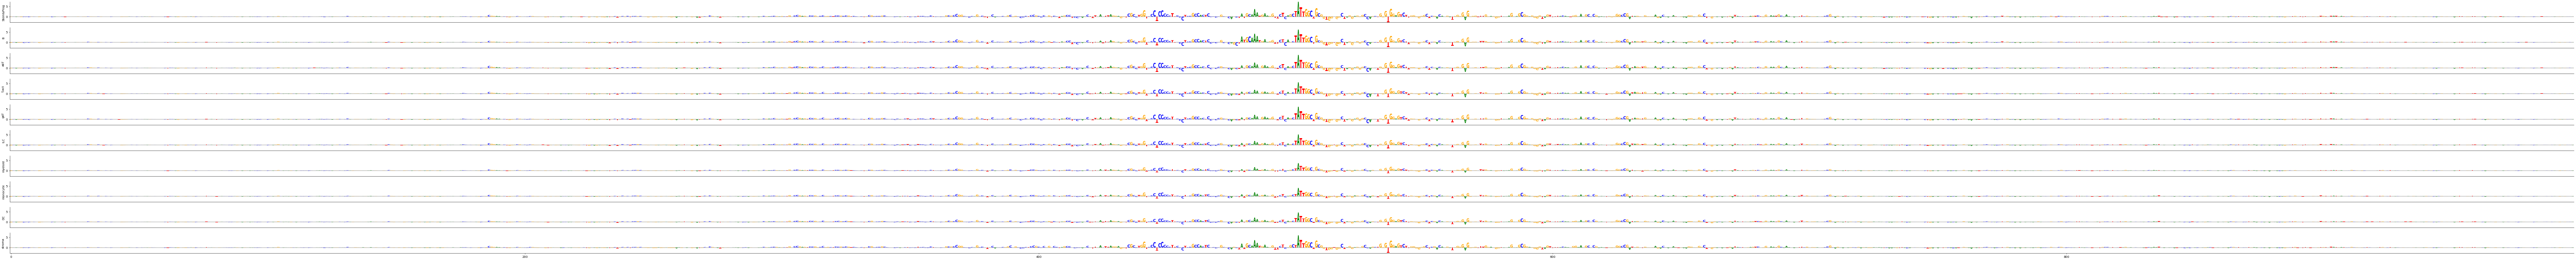

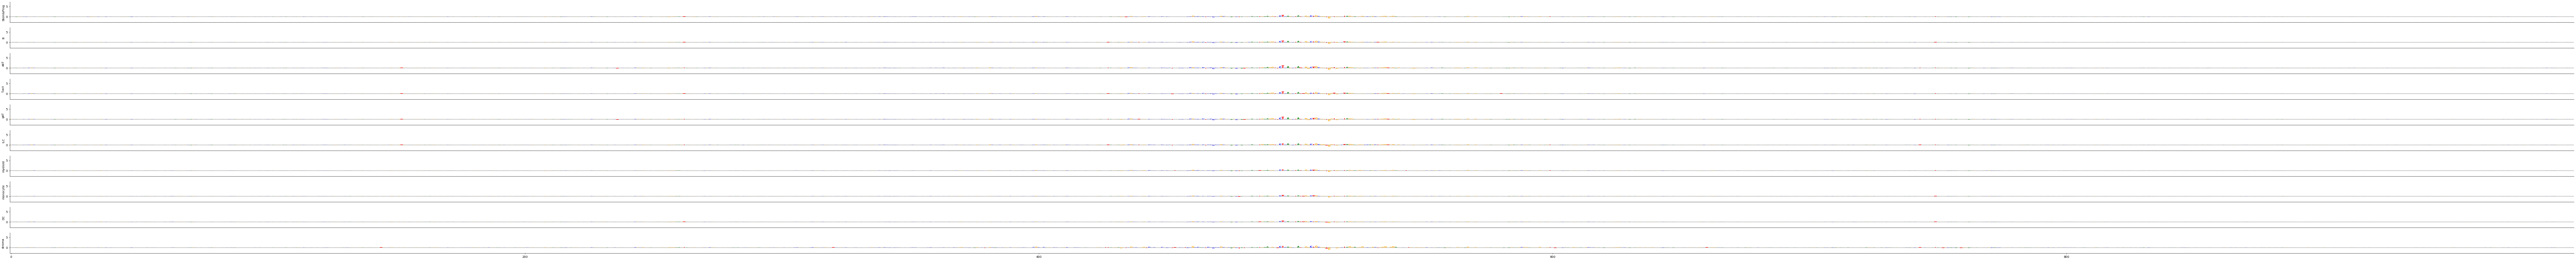

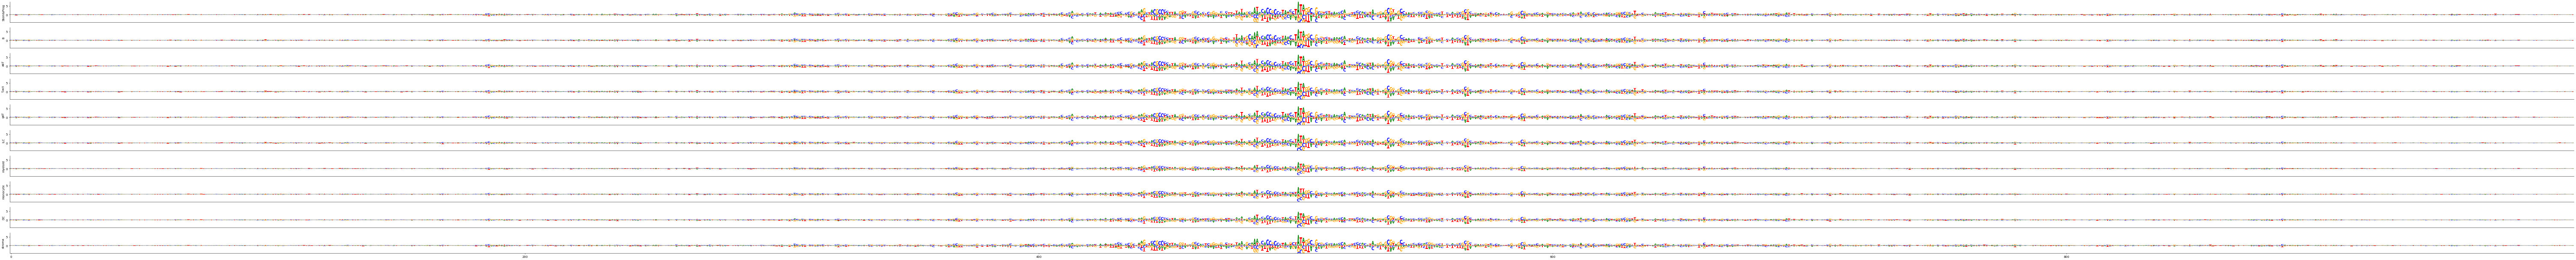

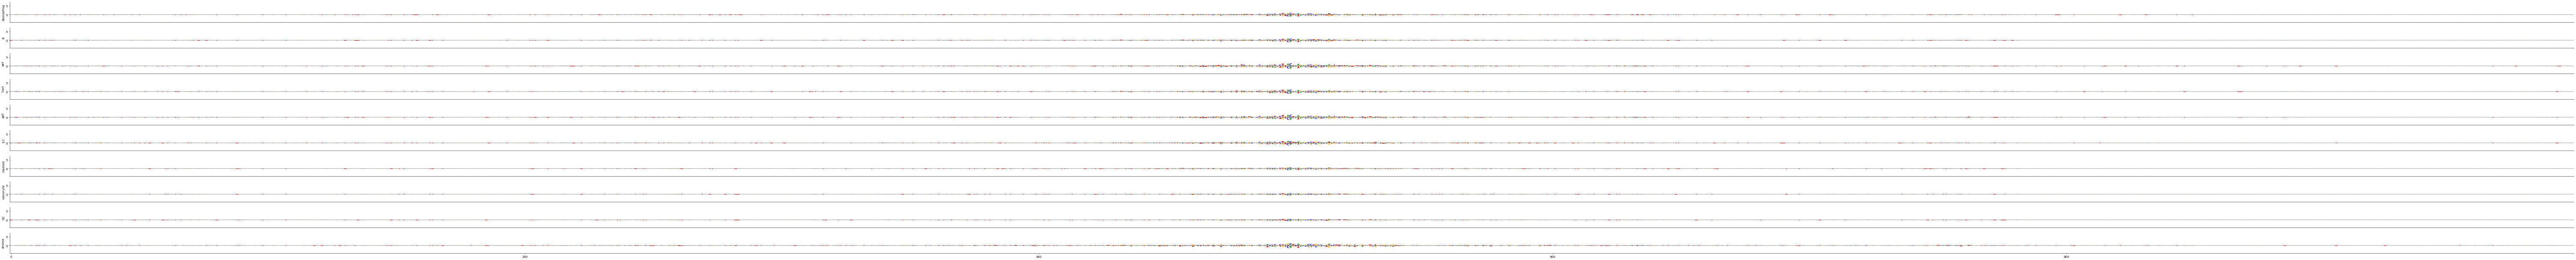

In [3]:
import matplotlib.pyplot as plt
import drg_tools.plotlib as drgplt
import numpy as np

# Find sequence with most motifs
N_motifs0 = np.array(N_motifs[0])
print(N_motifs0.shape)
N_motifs0_mean = np.mean(N_motifs0, axis = 0)
argmax = np.argsort(N_motifs0_mean)[-2]
print(np.array(N_motifs[0])[:, argmax])
print(np.array(N_motifs[1])[:, argmax])
print(N_motifs0_mean[argmax])


ylim = [np.amin(L0p5_attributions[argmax] * onehot_seq[[argmax]]), np.amax(L0p5_attributions[argmax] * onehot_seq[[argmax]])]
# Plot attributions for bpAI-TAC
figp5 = drgplt.plot_attribution_maps(L0p5_attributions[argmax] * onehot_seq[[argmax]],experiments=lineage_names, vlim = ylim)

# Plot attributions for AI-TAC
fig0 = drgplt.plot_attribution_maps(L0_attributions[argmax] * onehot_seq[[argmax]],experiments=lineage_names, vlim = ylim)

ylim = [np.amin(L0p5_attributions[argmax]), np.amax(L0p5_attributions[argmax])]
# Plot attributions for bpAI-TAC
figp5all = drgplt.plot_attribution_maps(L0p5_attributions[argmax] ,experiments=lineage_names, vlim = ylim)

# Plot attributions for AI-TAC
fig0all = drgplt.plot_attribution_maps(L0_attributions[argmax] ,experiments=lineage_names, vlim = ylim)

plt.show()

### Cluster motifs

Computing distance matrix of size 29485
Distance matrix of size (29485, 29485) computed in 455.7425775527954
Clustering with matrix of size (29485, 29485) computed in 25.492064952850342


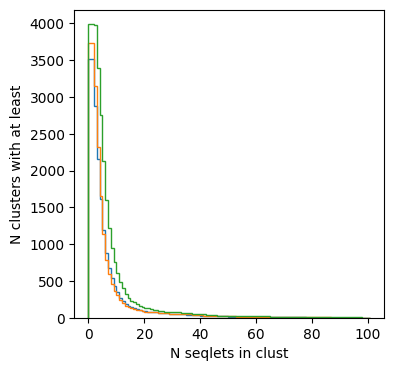

29485 form 4006 clusters
4006
Saved PWM File as : /home/sasse/UW/BPAI-TAC/Attributions/Seqletscluster0.001_cwms.meme


In [2]:
from drg_tools.motif_analysis import combine_pwms, torch_compute_similarity_motifs
import numpy as np
from drg_tools.io_utils import write_meme_file
import drg_tools.plotlib as drgplt
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import time
import os

# Load saved seqlets
dir_path = os.path.expanduser('~/UW/BPAI-TAC/Attributions/')
seqlet_file = os.path.join(dir_path, 'Seqlets.npz')
sfile = np.load(seqlet_file, allow_pickle= True)
selected_names, motif_names, header, normed_motifs, motif_mean_effect, motif_max_effect, motif_borders = sfile['seqnames'], sfile['names'], sfile['cells'], sfile['seqlets'], sfile['mean_effect'], sfile['max_effect'], sfile['borders']

# Make it a list and provide the seqlets in shape (l,4) to the algorithm
normed_motifs_Lp5 = [nm.T for nmm in normed_motifs[0] for nm in nmm]
normed_motifs_L0 = [nm.T for nmm in normed_motifs[1] for nm in nmm]
motifs = normed_motifs_Lp5 + normed_motifs_L0
motif_names_Lp5 = np.concatenate(motif_names[0])
motif_names_L0 = np.concatenate(motif_names[1])
motif_names_full = np.append(np.concatenate(motif_names[0]), np.concatenate(motif_names[1]))
# Compute distance matrix between all seqlets from all cell types
# if return_alignment = True, then it returns the best offsets, and a binary matrix if the forward or reverse motif was aligned
# As distance metric, we are using the pvalue of the correlation coefficient
t0 = time.time()
print(f'Computing distance matrix of size {len(motifs)}')
motif_distance, offsets, revcomp_matrix = torch_compute_similarity_motifs(motifs, motifs, 
                                    metric = 'correlation_pvalue', min_sim = 4, padding = 0., infocont = False, 
                                    bk_freq = 0.25, reverse_complement = True, verbose = False, device = 'cuda:0', 
                                    batchsize = 1024, exact = True, fill_logp_self = 127, return_alignment = True, 
                                    sparse = False)
print(f'Distance matrix of size {motif_distance.shape} computed in {time.time()-t0}')
# With a distance matrix, one can use an clustering algorithm that to determine groups
# Agglomerative clustering has the advantage that it is highly interpretable and that we can use a distance threshold
# instead of defining a fixed number of clusters
# We use complete linkage and a threshold of 0.05, i.e. every motif in the cluster has a p-value < 0.05 to all other motifs
# in the same group
t0 = time.time()
cluster_cutoff = 0.001 # combine all motifs that have p-value 0.05 or less to all other seqlets in cluster
clustering = AgglomerativeClustering(n_clusters = None, metric = 'precomputed', linkage = 'complete', 
                                     distance_threshold = cluster_cutoff)
clustering.fit(motif_distance)
print(f'Clustering with matrix of size {motif_distance.shape} computed in {time.time()-t0}')
clusters = clustering.labels_

# We save the cluster assignments to a file
np.savetxt(os.path.splitext(seqlet_file)[0]+f'cluster{cluster_cutoff}.txt', np.array([motif_names_full, clusters], dtype = str).T, fmt = '%s')

# Let check the number of seqlets per cluster for each model
cluster_ids_lp5, n_seqlets_lp5 = np.unique(clusters[:len(motif_names_Lp5)], return_counts=True)
cluster_ids_l0, n_seqlets_l0 = np.unique(clusters[-len(motif_names_Lp5):], return_counts=True)
cluster_ids, n_seqlets = np.unique(clusters, return_counts = True)

fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111)
ax.hist(n_seqlets_lp5, bins = np.arange(0,102,1), cumulative = -1, histtype='step')
ax.hist(n_seqlets_l0, bins = np.arange(0,102,1), cumulative = -1, histtype='step')
ax.hist(n_seqlets, bins = np.arange(0,102,1), cumulative = -1, histtype='step')
ax.set_xlabel('N seqlets in clust')
ax.set_ylabel('N clusters with at least')
plt.show()

print(f'{motif_distance.shape[0]} form {len(cluster_ids)} clusters')

# Combine sequences to CWM and save as meme file
cluster_cwms = combine_pwms(motifs, clusters, 1.-motif_distance, offsets, revcomp_matrix)
write_meme_file(cluster_cwms, cluster_ids.astype(str), 'ACGT', os.path.splitext(seqlet_file)[0]+f'cluster{cluster_cutoff}_cwms.meme', round = 2)



4006 clusters form 902 reduced clusters
[]
Cluster 0 has 11 seqlets
Cluster 1 has 29 seqlets
Cluster 2 has 72 seqlets
Cluster 3 has 16 seqlets
Cluster 4 has 14 seqlets
Cluster 5 has 46 seqlets
Cluster 6 has 34 seqlets
Cluster 7 has 15 seqlets
Cluster 8 has 487 seqlets
Cluster 9 has 58 seqlets
Cluster 10 has 54 seqlets
Cluster 11 has 14 seqlets
Cluster 12 has 43 seqlets
Cluster 13 has 26 seqlets
Cluster 14 has 26 seqlets
Cluster 15 has 42 seqlets
Cluster 16 has 142 seqlets
Cluster 17 has 1385 seqlets
Cluster 18 has 27 seqlets
Cluster 19 has 22 seqlets
Cluster 20 has 37 seqlets
Cluster 21 has 16 seqlets
Cluster 22 has 35 seqlets
Cluster 23 has 12 seqlets
Cluster 24 has 30 seqlets
Cluster 25 has 23 seqlets
Cluster 26 has 26 seqlets
Cluster 27 has 51 seqlets
Cluster 28 has 36 seqlets
Cluster 29 has 6 seqlets
Cluster 30 has 51 seqlets
Cluster 31 has 24 seqlets
Cluster 32 has 46 seqlets
Cluster 33 has 22 seqlets
Cluster 34 has 13 seqlets
Cluster 35 has 38 seqlets
Cluster 36 has 196 seqlets
C

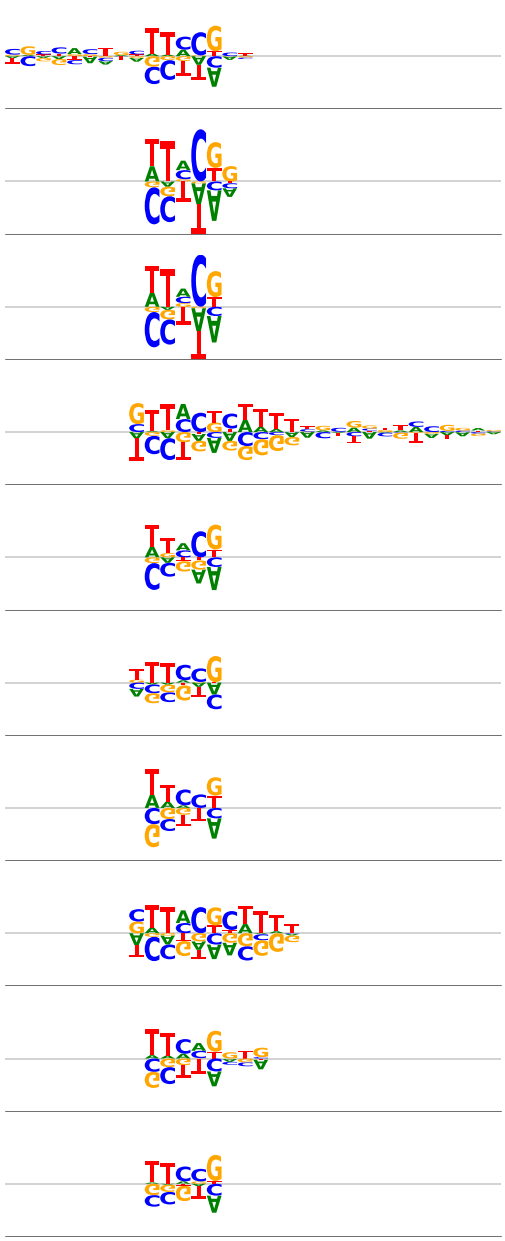

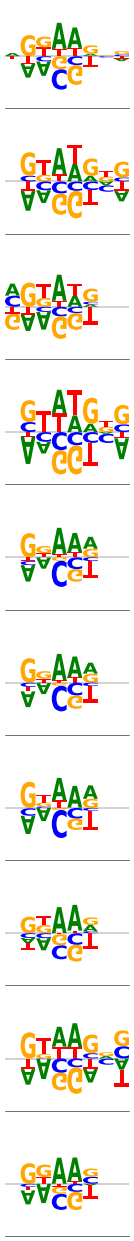

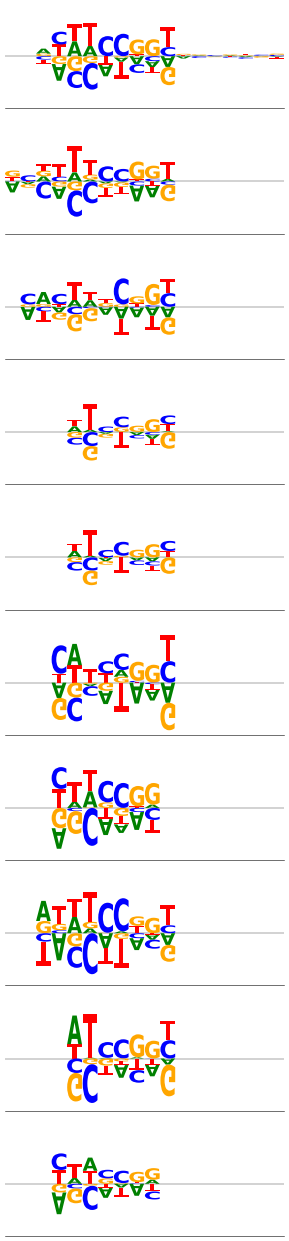

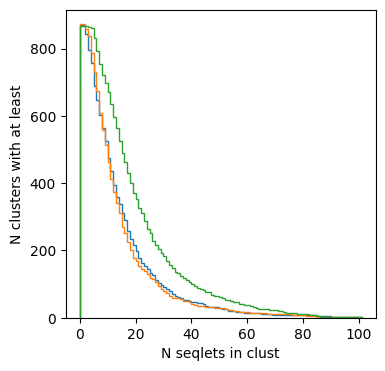

In [6]:
from drg_tools.io_utils import read_meme
import os
import numpy as np
from drg_tools.motif_analysis import combine_pwms, torch_compute_similarity_motifs
from drg_tools.io_utils import write_meme_file
import drg_tools.plotlib as drgplt
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import time


# It might be worth performing a second round of clustering on the combined cwms
# to eliminate anything that looks similar to our eyes
# CWMs can look more similar than individual seqlets from two clusters because the alignment removes overhanging pieces

dir_path = os.path.expanduser('~/UW/BPAI-TAC/Attributions/')
seqlet_file = os.path.join(dir_path, 'Seqlets.npz')

sfile = np.load(seqlet_file, allow_pickle= True)
selected_names, motif_names, header, normed_motifs, motif_mean_effect, motif_max_effect, motif_borders = sfile['seqnames'], sfile['names'], sfile['cells'], sfile['seqlets'], sfile['mean_effect'], sfile['max_effect'], sfile['borders']

# Make it a list and provide the seqlets in shape (l,4) to the algorithm
normed_motifs_Lp5 = [nm.T for nmm in normed_motifs[0] for nm in nmm]
normed_motifs_L0 = [nm.T for nmm in normed_motifs[1] for nm in nmm]
motifs = normed_motifs_Lp5 + normed_motifs_L0
motif_names_Lp5 = np.concatenate(motif_names[0])
motif_names_L0 = np.concatenate(motif_names[1])
motif_names_full = np.append(np.concatenate(motif_names[0]), np.concatenate(motif_names[1]))

cwm_meme = os.path.splitext(seqlet_file)[0]+f'cluster{cluster_cutoff}_cwms.meme'
cluster_cwms, cluster_ids, nts = read_meme(cwm_meme, nameline = 'MOTIF')

cluster_file = os.path.splitext(seqlet_file)[0]+f'cluster{cluster_cutoff}.txt'
clusterdata = np.genfromtxt(cluster_file, dtype = str)
motif_names_full, clusters = clusterdata[:,0], clusterdata[:,1].astype(int)

cluster_ids, n_seqlets = np.unique(clusters, return_counts = True)

# Recluster the combined cwms

# Compute distance between cluster_cwms
cwm_distance, cwm_offsets, cwm_revcomp_matrix = torch_compute_similarity_motifs(cluster_cwms, cluster_cwms, 
                                    metric = 'correlation_pvalue', min_sim = 4, padding = 0., infocont = False, 
                                    bk_freq = 0.25, reverse_complement = True, verbose = False, device = 'cuda:0', 
                                    batchsize = 1024, exact = True, fill_logp_self = 127, return_alignment = True, 
                                    sparse = False)
# 2nd round of clustering
cwm_cutoff = 0.001 # combine all motifs that have p-value 0.0001 or less between all cwms
clustering = AgglomerativeClustering(n_clusters = None, metric = 'precomputed', linkage = 'complete', 
                                     distance_threshold = cwm_cutoff)
clustering.fit(cwm_distance)
cwm_clusters = clustering.labels_

cwm_cluster_id, cwm_n_clusters = np.unique(cwm_clusters, return_counts = True)
print(f'{len(cwm_clusters)} clusters form {len(cwm_cluster_id)} reduced clusters')

# Write new cluster file
new_clusters = -np.ones_like(clusters)
for cid in cwm_cluster_id:
    affected_clusters = cluster_ids[cwm_clusters == cid]
    new_clusters[np.isin(clusters, affected_clusters)] = cid
print(new_clusters[new_clusters == -1])
np.savetxt(os.path.splitext(seqlet_file)[0]+f'cwmcluster{cwm_cutoff}.txt', np.array([motif_names_full, new_clusters], dtype = str).T, fmt = '%s')

# Combine seqlets of cwms in the same cluster
cluster_cwms_combined = []
for cic in cwm_cluster_id:
    if cic != -1:
        cmask = new_clusters == cic
        print(f'Cluster {cic} has {np.sum(cmask)} seqlets')
        cmotifs = [motifs[m] for m in np.where(new_clusters == cic)[0]]
        if len(cmotifs) > 1:
            corr_left, ofs_left, revcomp_matrix_left = torch_compute_similarity_motifs(cmotifs, cmotifs,
                                    metric = 'correlation_pvalue', min_sim = 4, padding = 0., infocont = False, 
                                    bk_freq = 0.25, reverse_complement = True, verbose = False, device = 'cuda:0', 
                                    batchsize = 1024, exact = True, fill_logp_self = 127, return_alignment = True, 
                                    sparse = False)
            cluster_cwms_combined.append(combine_pwms(cmotifs, np.zeros(len(cmotifs)), 1.-corr_left, ofs_left, revcomp_matrix_left)[0])
        else:
            cluster_cwms_combined.append(cmotifs[0])
    
write_meme_file(cluster_cwms_combined, cwm_cluster_id[cwm_cluster_id != -1].astype(str), 'ACGT', os.path.splitext(seqlet_file)[0]+f'cwmcluster{cwm_cutoff}_cwms.meme', round = 2)


# Check what kind of clusters are combined in second round
# Plot two cwms in same cluster with 10 of their individual pwms
maxclust = cwm_cluster_id[np.argmax(cwm_n_clusters)]
orig_maxclust = cluster_ids[cwm_clusters == maxclust]
print(f'After second round clustering the cluster {maxclust} has these clusters {orig_maxclust}')

# Create a list with the cluster_cwm and the set of individual seqlets for the first two clusters in the joint cluster
pwm_set = [cluster_cwms[orig_maxclust[0]]]
seqlets_pwm_set = [motifs[i] for i in np.where(clusters == orig_maxclust[0])[0]]
pwm_set = pwm_set + seqlets_pwm_set[:9]

# Compute the distance matrix between the seqlets to check if complete linkage is appropriate
motif_distance, offsets, revcomp_matrix = torch_compute_similarity_motifs(seqlets_pwm_set, seqlets_pwm_set,
                                    metric = 'correlation_pvalue', min_sim = 4, padding = 0., infocont = False,
                                    bk_freq = 0.25, reverse_complement = True, verbose = False, device = 'cuda:0',
                                    batchsize = 1024, exact = True, fill_logp_self = 127, return_alignment = True,
                                    sparse = False)
# Print the distance matrix
print(f'Motif distance matrix of size {motif_distance.shape}')
print(np.amax(motif_distance))
fig0 = drgplt.plot_pwms(pwm_set, log = False, showaxes = False, unit = 0.4, channels= list('ACGT'), 
                        offsets = None, revcomp_matrix = True, align_to = 0)


# Repeat for the second cluster
pwm_set = [cluster_cwms[orig_maxclust[1]]]
seqlets_pwm_set = [motifs[i] for i in np.where(clusters == orig_maxclust[1])[0]]
pwm_set = pwm_set + seqlets_pwm_set[:9]

# Compute the distance matrix between the seqlets to check if complete linkage is appropriate
motif_distance, offsets, revcomp_matrix = torch_compute_similarity_motifs(seqlets_pwm_set, seqlets_pwm_set,
                                    metric = 'correlation_pvalue', min_sim = 4, padding = 0., infocont = False,
                                    bk_freq = 0.25, reverse_complement = True, verbose = False, device = 'cuda:0',
                                    batchsize = 1024, exact = True, fill_logp_self = 127, return_alignment = True,
                                    sparse = False)
# Print the distance matrix
print(f'Motif distance matrix of size {motif_distance.shape}')
print(np.amax(motif_distance))

fig1 = drgplt.plot_pwms(pwm_set, log = False, showaxes = False, unit = 0.4, channels= list('ACGT'), 
                        offsets = None, revcomp_matrix = True, align_to = 0)

# Repeat for the second cluster
pwm_set = [cluster_cwms[orig_maxclust[2]]]
seqlets_pwm_set = [motifs[i] for i in np.where(clusters == orig_maxclust[2])[0]]
pwm_set = pwm_set + seqlets_pwm_set[:9]

# Compute the distance matrix between the seqlets to check if complete linkage is appropriate
motif_distance, offsets, revcomp_matrix = torch_compute_similarity_motifs(seqlets_pwm_set, seqlets_pwm_set,
                                    metric = 'correlation_pvalue', min_sim = 4, padding = 0., infocont = False,
                                    bk_freq = 0.25, reverse_complement = True, verbose = False, device = 'cuda:0',
                                    batchsize = 1024, exact = True, fill_logp_self = 127, return_alignment = True,
                                    sparse = False)
# Print the distance matrix
print(f'Motif distance matrix of size {motif_distance.shape}')
print(np.amax(motif_distance))

fig2 = drgplt.plot_pwms(pwm_set, log = False, showaxes = False, unit = 0.4, channels= list('ACGT'), 
                        offsets = None, revcomp_matrix = True, align_to = 0)

plt.show()



# Let check the number of seqlets per cluster for each model
cluster_ids_lp5, n_seqlets_lp5 = np.unique(new_clusters[:len(motif_names_Lp5)], return_counts=True)
cluster_ids_l0, n_seqlets_l0 = np.unique(new_clusters[-len(motif_names_Lp5):], return_counts=True)
cluster_ids, n_seqlets= np.unique(new_clusters, return_counts=True)
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111)
ax.hist(n_seqlets_lp5, bins = np.arange(0,102,1), cumulative = -1, histtype='step')
ax.hist(n_seqlets_l0, bins = np.arange(0,102,1), cumulative = -1, histtype='step')
ax.hist(n_seqlets, bins = np.arange(0,102,1), cumulative = -1, histtype='step')
ax.set_xlabel('N seqlets in clust')
ax.set_ylabel('N clusters with at least')
plt.show()


### Perform Fisher's exact test to detect enriched motifs


In [54]:
from drg_tools.io_utils import read_meme
from scipy.stats import fisher_exact
import os
import numpy as np
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html

dir_path = os.path.expanduser('~/UW/BPAI-TAC/Attributions/')
seqlet_file = os.path.join(dir_path, 'Seqlets.npz')

cwm_meme = os.path.splitext(seqlet_file)[0]+'cluster_cwms.meme'
cluster_cwms, cluster_ids, nts = read_meme(cwm_meme, nameline = 'MOTIF')

cluster_file = os.path.splitext(seqlet_file)[0]+'cluster.txt'
clusterdata = np.genfromtxt(cluster_file, dtype = str)
motif_names_full, clusters = clusterdata[:,0], clusterdata[:,1].astype(int)

cluster_ids, n_seqlets = np.unique(clusters, return_counts = True)

seq_names = np.array([mn.rsplit('_',3)[0] for mn in motif_names_full]) # Perform enichtment at sequence level
model_names = np.array([mn.rsplit('_',3)[1] for mn in motif_names_full]) 

seqs_with_motifs = np.unique(seq_names)
M = len(seqs_with_motifs)
lp5mask = model_names == 'L05'
l0mask = model_names == 'L0'
Mn = len(np.unique(seq_names[lp5mask]))
MN = len(np.unique(seq_names[l0mask]))

p_values = []
cluster_numbers = [[],[]]
selected_cwms = []
for cid in cluster_ids:
    mask = clusters == cid # cluster mask
    seq_lp5 = np.unique(seq_names[mask * lp5mask]) # all sequences with cluster and in lp5 model
    seq_l0 = np.unique(seq_names[mask * l0mask]) # all sequences with cluster and l0 model
    common_seq = np.intersect1d(seq_lp5, seq_l0) # number of common seuqences
    x = len(common_seq) # found by both models
    n = len(seq_lp5)
    N = len(seq_l0)
    cluster_numbers[0].append(n/M)
    cluster_numbers[1].append(N/M)
    #table = [[x, n - x], [N - x, M - (n + N) + x]] # (fix to) rows: has motif in model A, does not have motif in model A, columns: has motif in model B, does not have motif in model B

    table = [[n,N], [Mn-n, MN-N]] # rows: has motif, does not have motif, columns: model lp5, model l0
    p = fisher_exact(table, alternative='greater')[1]
    p_values.append(p)
    if p < 0.01/len(cluster_ids): #(n-N>10) and ((n-N)/(n+N-x) > 0.6):
        selected_cwms.append(cid)
        print(table, p)
    

print(f'Selected {len(selected_cwms)} clusters')

#from scipy.stats import false_discovery_control 
#correlation_qvalue = false_discovery_control(correlation_pvalue, axis=1, method='bh')

[[93, 4], [949, 845]] 2.2158995811811222e-20
[[143, 51], [899, 798]] 1.4574343321867992e-08
[[189, 5], [853, 844]] 1.7570070569092166e-45
[[105, 31], [937, 818]] 2.4718777969040155e-08
[[112, 14], [930, 835]] 2.886075087398942e-17
[[120, 12], [922, 837]] 1.832082529057735e-20
[[28, 2], [1014, 847]] 4.704870529628724e-06
[[76, 7], [966, 842]] 1.3329780063838173e-13
[[37, 2], [1005, 847]] 3.2717148377680293e-08
[[42, 7], [1000, 842]] 4.133660742046915e-06
[[150, 48], [892, 801]] 1.8735229254265567e-10
[[58, 4], [984, 845]] 1.2956561231452049e-11
[[161, 11], [881, 838]] 1.4872725804743414e-31
[[82, 7], [960, 842]] 5.064704799090254e-15
[[106, 32], [936, 817]] 3.468728533015296e-08
[[22, 0], [1020, 849]] 1.828872079923967e-06
[[183, 24], [859, 825]] 1.2491162046440196e-27
[[38, 0], [1004, 849]] 1.0731105830245238e-10
[[35, 1], [1007, 848]] 1.1444397843988897e-08
[[25, 0], [1017, 849]] 2.968759197445397e-07
[[31, 3], [1011, 846]] 4.917773059198322e-06
[[21, 0], [1021, 849]] 3.34964817772558

### Transform CWMs to PWMs and compare to database of TFs


In [53]:
#Load the motifs from the meme file
from drg_tools.io_utils import read_meme, write_meme_file
import os
import numpy as np
import drg_tools.plotlib as drgplt
import matplotlib.pyplot as plt
import sys

dir_path = os.path.expanduser('~/UW/BPAI-TAC/Attributions/')
seqlet_file = os.path.join(dir_path, 'Seqlets.npz')

cwm_meme = os.path.splitext(seqlet_file)[0]+'cluster_cwms.meme'
cluster_cwms, cluster_ids, nts = read_meme(cwm_meme, nameline = 'MOTIF')
cluster_ids = cluster_ids.astype(int)

# Download motif databases here https://meme-suite.org/meme/meme-software/Databases/motifs/motif_databases.12.25.tgz
# Load pwms of motif database 
database=os.path.expanduser('~/data/motif_databases/motif_databases/JASPAR/JASPAR2022_CORE_vertebrates_non-redundant_v2TF.meme')
TF_pfms, TFnames, nts = read_meme(database, nameline = 'MOTIF')

# Compute similarity matrix between cwms and pwms with drg and regturn correlation_pvalue
# Transform pfms to pwms
pseudo = 0.01 # pseudo count added to avoid large negative values 
TF_pwms = []
for tfpf in TF_pfms:
    tfpw = np.log2((tfpf+pseudo)/(0.25+pseudo))
    # We set negative values to zero to avoid any influence from low prob. bases
    tfpw[tfpw<0] = 0 
    TF_pwms.append(tfpw)
tfpwmlen = np.array([tfpwm.shape[0] for tfpwm in TF_pwms])
tfpwmminlen = np.amin(tfpwmlen)

from drg_tools.motif_analysis import torch_compute_similarity_motifs
# Potentially modify the cwms with exp, normalize to sum to 1, and create pwm to be more comparable. 
cluster_pwms = []
cluster_pfms = []
cluster_cwms0 = []
# We have to transform CWMs to PWMs to compare them properly
for clcw in cluster_cwms:
    #clcw = np.exp(clcw) # Attributions are for log-fold changes ### MUltiplier does not change anything
    clcw[clcw < 0 ] = 0
    cluster_cwms0.append(clcw)
    clcwsum = np.sum(np.abs(clcw), axis = 1) # Normalize them to probabilities
    if 0 in clcwsum: 
        clcwsum[clcwsum == 0] = 1. 
    mask = np.where(clcwsum/np.amax(clcwsum) > 0.05)[0] # Remove positions with consistently low attributions
    masklen = mask[-1] - mask[0] +1
    if masklen < tfpwmminlen:
        add_left = (tfpwmminlen - masklen) // 2
        mask_left = max(mask[0] - add_left, 0)
        mask = [mask_left, mask_left +6]
    clcw = clcw[mask[0]:mask[-1]+1]/clcwsum[mask[0]:mask[-1]+1][:,None] # Normalize to probabilities
    cluster_pfms.append(clcw) 
    clcw = np.log2((clcw+pseudo)/(0.25+pseudo))
    clcw[clcw < 0] = 0
    cluster_pwms.append(clcw)

'''    
# Return p-values for correlation
correlation_pvalue = torch_compute_similarity_motifs(cluster_cwms0, TF_pwms, metric = 'correlation_pvalue', min_sim = 4, 
                                                     padding = 0, infocont = False, bk_freq = 0., reverse_complement = True, 
                                                     verbose = False, batchsize = 1024, exact = True, fill_logp_self = 127, 
                                                     return_alignment = False )

write_meme_file(cluster_pfms, cluster_ids.astype(str), 'ACGT', os.path.splitext(seqlet_file)[0]+'cwmcluster_pfms.meme', round = 3)

# The algorithm sets negative correlations to be larger than 1
correlation_pvalue[correlation_pvalue>1] = 1
'''
from tangermeme.tools.tomtom import tomtom
print(f'Computing distance matrix of size {len(cluster_pfms)}, {len(TF_pwms)}')
time0 = time.time()
correlation_pvalue, correlation_scores, offsets, overlaps, strands = tomtom([cfm.T for cfm in cluster_pfms], [tfm.T for tfm in TF_pfms])
print(f'Tomtom executed in {time.time()-time0} for {correlation_pvalue.shape}')
correlation_pvalue = correlation_pvalue.numpy()
correlation_pvalue[correlation_pvalue>1] = 1
correlation_pvalue[correlation_pvalue<0] = 0

# correct for multiple testing along the axis of the motif database, with bejamini hochberg method
from scipy.stats import false_discovery_control 
correlation_qvalue = false_discovery_control(correlation_pvalue, axis=1, method='bh')
# Bonferroni correction
#correlation_qvalue = correlation_pvalue*correlation_pvalue.shape[1]

# write tomtom.tsv file for all matches with q < 0.05, and assign TF names to cluster name
cluster_name = []
q_cut = 0.05
tomtom = os.path.splitext(cwm_meme)[0]+'.tomtom.tsv'
obj = open(tomtom, 'w')
obj.write('Query_ID\tTarget_ID\tOptimal_offset\tp-value\tCorrelation\tq-value\tOrientation\n')
for c, cid in enumerate(cluster_ids):
    cname = str(cid)
    if (correlation_qvalue[c] < q_cut).any():
        cname += '('
        sort = np.argsort(correlation_qvalue[c])
        q, p, tid = correlation_qvalue[c][sort], correlation_pvalue[c][sort], TFnames[sort]
        #print(q, p, tid)
        cn = 0 
        for s in range(len(sort)):
            if q[s] < q_cut:
                obj.write(str(cid)+'\t'+tid[s]+'\t.\t'+str(p[s])+'\t'+str(p[s])+'\t'+str(q[s])+'\t.\n')
                if cn < 5:
                    cname += tid[s]+';'
                    cn += 1
        cname = cname.strip(';')+')'
        # Quick check in line
        ntfhits = np.sum(q<q_cut)
        print(cname, ntfhits)
        '''
        test_pwms = [cluster_pwms[c]] + [cluster_cwms[c]] + [TF_pwms[s] for s in sort[:min(10, ntfhits)]]
        fig1 = drgplt.plot_pwms(test_pwms, log = False, showaxes = False, unit = 0.4, channels= list('ACGT'), 
                        offsets = None, revcomp_matrix = True, align_to = 0)
        plt.show()
        plt.close()
        if c == 10:
            sys.exit()
        '''
    cluster_name.append(cname)

cluster_name = np.array(cluster_name)




Computing distance matrix of size 1454, 841
Tomtom executed in 2.5538902282714844 for torch.Size([1454, 841])
1(MEIS2) 1
6(RUNX2;RUNX3;IRF4;Bcl11B;IRF9) 12
10(Nr1H4;Nr1H2;NR2F2;ESRRB;Rarg) 8
16(Stat5a) 1
21(ETS1;FLI1;ERF;ETV2;ETV4) 45
28(ZNF740) 1
29(ZBTB6) 1
35(FOSL2::JUND;FOSL2::JUNB;FOSB::JUNB;FOS::JUN;JDP2) 32
41(RUNX2;Bcl11B;RUNX3;Runx1) 4
45(CTCF;CTCF;CTCF;CTCFL) 4
51(Zfx) 1
56(ETV5;ETV4;ELK1;ETS2;ELK3) 51
70(RUNX2;Runx1) 2
79(CEBPG;CEBPE;CEBPB) 3
96(Znf423;EBF1) 2
98(ETV5::DRGX;FLI1::DRGX;ETV5::HOXA2;ETS2;ERF::HOXB13) 56
118(Rhox11) 1
119(ETS1;FLI1;ETV4;ELK4;ERF) 52
125(FOSL2;FOS;FOSL2::JUNB;FOSB::JUNB;FOSL2::JUND) 32
128(SPIC;Spi1;SPIB;ETV7;ETV6) 47
129(RUNX2;RUNX3;Bcl11B;Runx1) 4
131(STAT1::STAT2;IRF9;IRF8;IRF4;IRF3) 11
133(ETS1;FLI1;ETS2;ERF;FLI1::DRGX) 54
134(ETS1;FLI1;ERF;ETS2;ETV4) 55
142(ETV2::FOXI1;FLI1::FOXI1;ERF::FOXI1;ETS1;ETS2) 44
154(Atf1;JDP2;FOSL2::JUN;FOSB::JUN;FOS) 22
167(Ikzf3;Erg;FOXJ2::ELF1;GABPA;ELF1) 46
181(PKNOX2;ERF::FIGLA;HES6;Ptf1A;TGIF2) 22
183(RELA;NF

### Plot motifs with detected numbers in tree

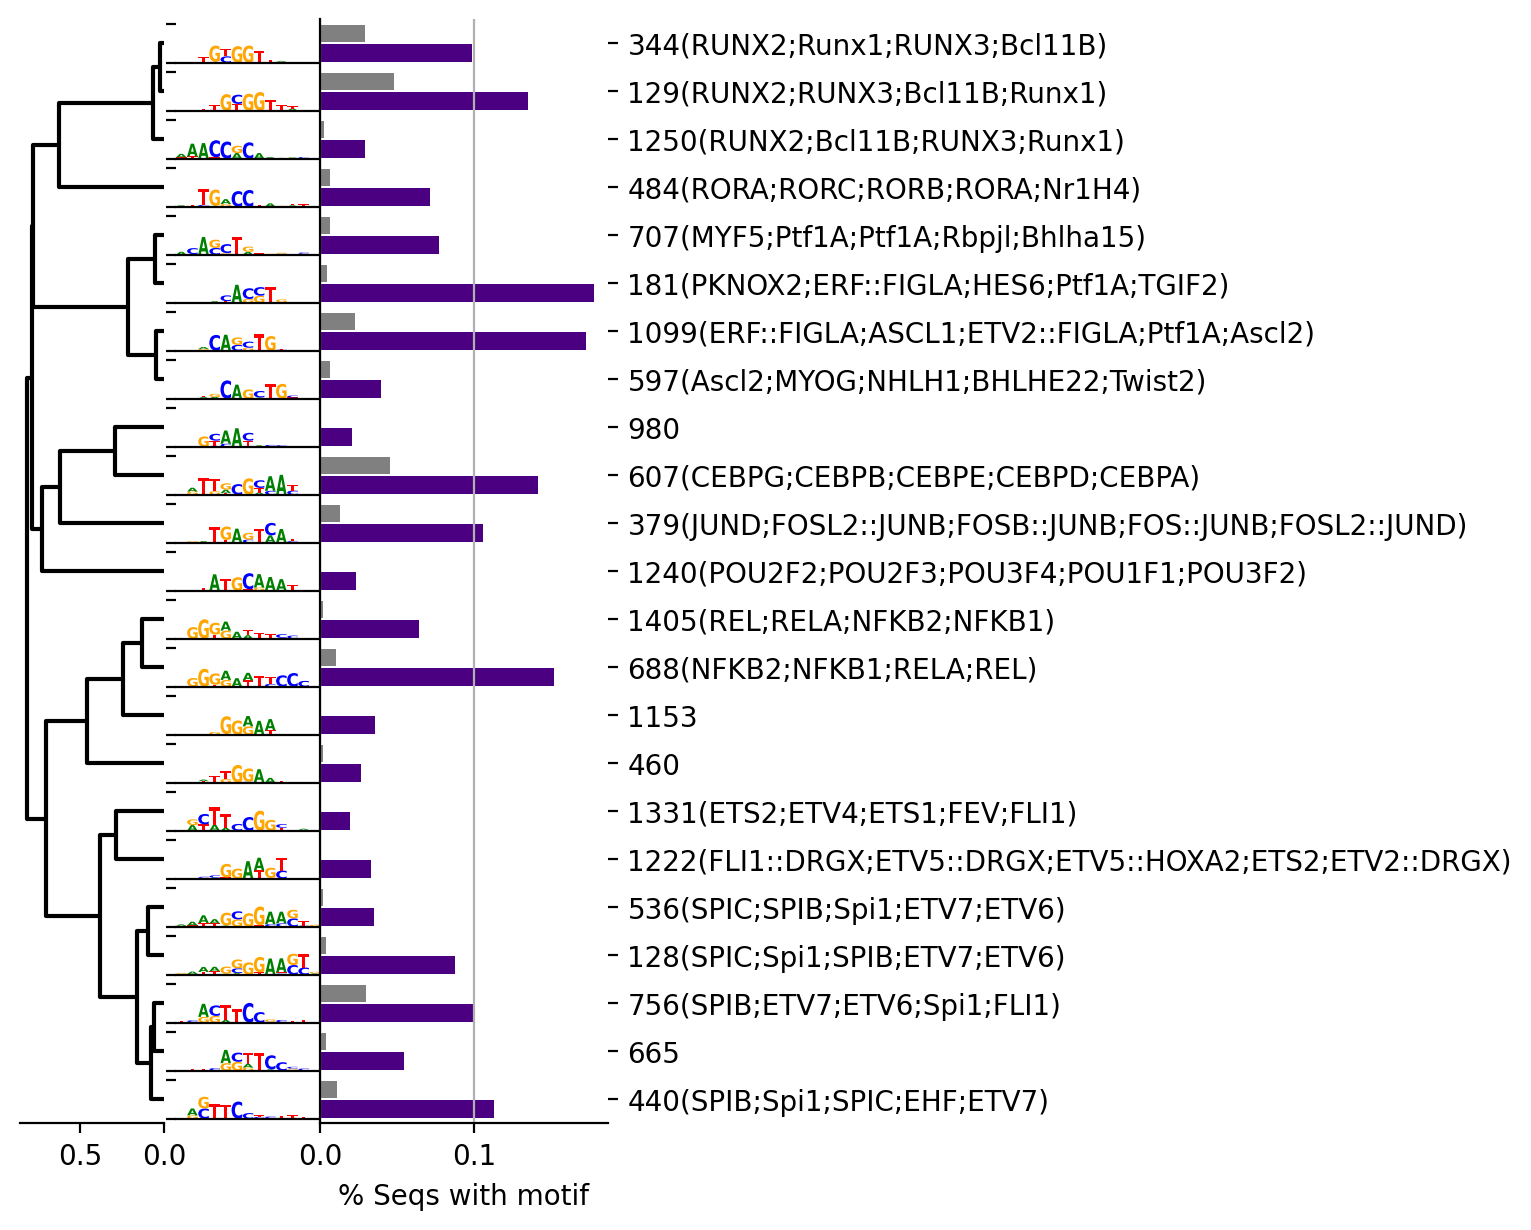

(None,
 [5,
  11,
  14,
  0,
  8,
  18,
  21,
  6,
  17,
  12,
  22,
  19,
  4,
  10,
  15,
  9,
  16,
  2,
  13,
  7,
  20,
  1,
  3])

In [56]:
import drg_tools.plotlib as drgplt
from drg_tools.motif_analysis import torch_compute_similarity_motifs

selected_cluster_cwms = [cw for c, cw in enumerate(cluster_cwms) if cluster_ids[c] in selected_cwms]
selected_cluster_pwms = [pw for c, pw in enumerate(cluster_pwms) if cluster_ids[c] in selected_cwms]
selected_cluster_pfms = [pf for c, pf in enumerate(cluster_pfms) if cluster_ids[c] in selected_cwms]

# Compute the correlation distance matrix between the selected cluster motifs
cwm_correlation = torch_compute_similarity_motifs(selected_cluster_cwms, selected_cluster_cwms, metric = 'correlation', min_sim = 4, 
                                                     padding = 0., infocont = False, bk_freq = 0.25, reverse_complement = True, 
                                                     verbose = False, batchsize = 1024, exact = True, fill_logp_self = 127, 
                                                     return_alignment = False)

drgplt.plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = cwm_correlation, # matrix to compute sorty, default uses heatmat
                 sorty = 'average', # same as above but for y axis
                 pwms = selected_cluster_cwms, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = False, 
                 yticklabels  = cluster_name[np.isin(cluster_ids, selected_cwms)],
                 showdpi = 200, # dpi value for plotting with plt.show()
                 dpi = None, # dpi value for savefig
                 figname = None, # if given, figure saved under this name
                 fmt = '.jpg', # format of saved figure
                 maxsize = 150, # largest size the figure can take along both axis
                 cellsize = 0.3, # size of a single cell in the heatmap
                 cellratio = 1., # ratio of cells y/x
                 noheatmap = True, # if True, only tree is plotted
                 row_distributions = np.array(cluster_numbers)[:, np.isin(cluster_ids, selected_cwms)][:,:, None], # for each row in heatmap, add 
                 # a box or a bar plot with plot_distribution, 
                 row_distribution_kwargs = {'barplot':True, 'split':2, 'facecolor':['indigo', 'grey'], 'ylabel' : '% Seqs with motif'} #, 'legend_labels' : ['bpAI-TAC','AI-TAC'], 'legend_above' : True} # kwargs fro plot_distribution
                 )

[[35, 4], [1007, 845]] 2.76558618934078e-06
[[162, 50], [880, 799]] 8.312146690306991e-12
[[87, 8], [955, 841]] 1.8017183429970478e-15
[[287, 160], [755, 689]] 5.3927631533151445e-06
[[170, 80], [872, 769]] 5.801631572778107e-06
[[111, 18], [931, 831]] 9.154167707498102e-15
[[270, 106], [772, 743]] 1.0611922170825858e-13
[[50, 5], [992, 844]] 5.411591692282509e-09
[[254, 25], [788, 824]] 4.634691137345907e-45
[[130, 49], [912, 800]] 3.2796468838094464e-07
[[96, 16], [946, 833]] 1.2259781256001891e-12
[[67, 6], [975, 843]] 3.24206650749337e-12
[[234, 79], [808, 770]] 3.964446398003056e-15
[[229, 25], [813, 824]] 1.927723820253575e-38
[[204, 34], [838, 815]] 8.622650611960852e-27
[[42, 3], [1000, 846]] 1.3744785522451175e-08
Selected 16 clusters
Computing distance matrix of size 902, 841
Tomtom executed in 1.7062995433807373 for torch.Size([902, 841])
8(SPIB;SPIC;Spi1;ETV7;ELF2) 10
11(REL) 1
16(SREBF1;USF2;BHLHE41;ERF::SREBF2;ERF::FIGLA) 33
17(ETS1;ETV4;FLI1;ERF;ETV3) 56
28(PITX1;PITX2;O

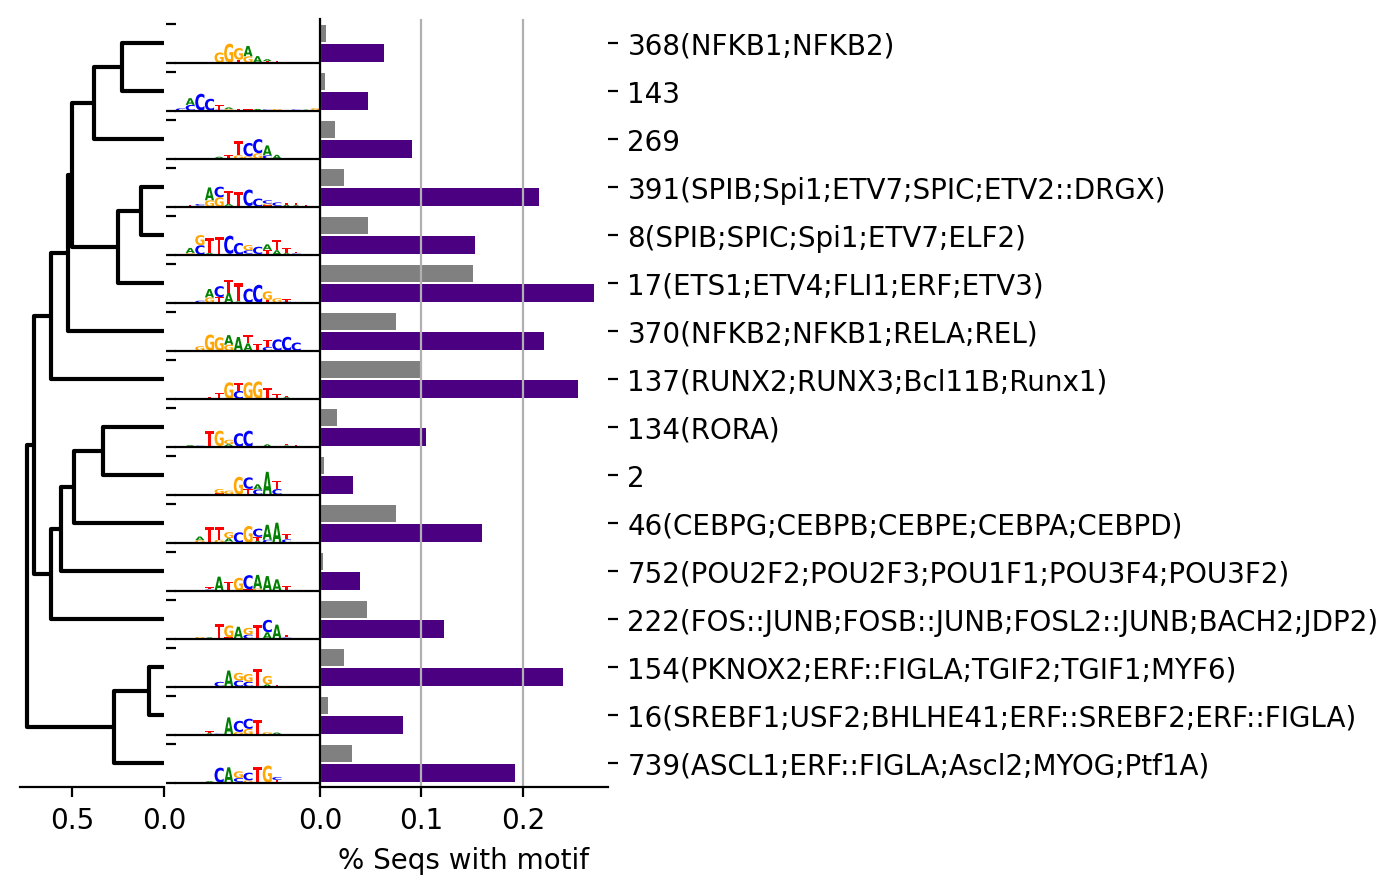

(None, [14, 2, 8, 9, 15, 4, 0, 5, 6, 12, 3, 1, 13, 10, 7, 11])

In [58]:
# Do the same for clusters with more stringent cutoff

from drg_tools.io_utils import read_meme
from scipy.stats import fisher_exact
import os
import numpy as np
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html

dir_path = os.path.expanduser('~/UW/BPAI-TAC/Attributions/')
seqlet_file = os.path.join(dir_path, 'Seqlets.npz')

cwm_meme = os.path.splitext(seqlet_file)[0]+'cwmcluster0.001_cwms.meme'
cluster_cwms, cluster_ids, nts = read_meme(cwm_meme, nameline = 'MOTIF')

cluster_file = os.path.splitext(seqlet_file)[0]+'cwmcluster0.001.txt'
clusterdata = np.genfromtxt(cluster_file, dtype = str)
motif_names_full, clusters = clusterdata[:,0], clusterdata[:,1].astype(int)

cluster_ids, n_seqlets = np.unique(clusters, return_counts = True)

seq_names = np.array([mn.rsplit('_',3)[0] for mn in motif_names_full]) # Perform enichtment at sequence level
model_names = np.array([mn.rsplit('_',3)[1] for mn in motif_names_full]) 

seqs_with_motifs = np.unique(seq_names)
M = len(seqs_with_motifs)
lp5mask = model_names == 'L05'
l0mask = model_names == 'L0'
Mn = len(np.unique(seq_names[lp5mask]))
MN = len(np.unique(seq_names[l0mask]))

p_values = []
cluster_numbers = [[],[]]
selected_cwms = []
for cid in cluster_ids:
    mask = clusters == cid # cluster mask
    seq_lp5 = np.unique(seq_names[mask * lp5mask]) # all sequences with cluster and in lp5 model
    seq_l0 = np.unique(seq_names[mask * l0mask]) # all sequences with cluster and l0 model
    common_seq = np.intersect1d(seq_lp5, seq_l0) # number of common seuqences
    x = len(common_seq) # found by both models
    n = len(seq_lp5)
    N = len(seq_l0)
    cluster_numbers[0].append(n/M)
    cluster_numbers[1].append(N/M)
    #table = [[x, n - x], [N - x, M - (n + N) + x]] # (fix to) rows: has motif in model A, does not have motif in model A, columns: has motif in model B, does not have motif in model B

    table = [[n,N], [Mn-n, MN-N]] # rows: has motif, does not have motif, columns: model lp5, model l0
    p = fisher_exact(table, alternative='greater')[1]
    p_values.append(p)
    if p < 0.01/len(cluster_ids): #(n-N>10) and ((n-N)/(n+N-x) > 0.6):
        selected_cwms.append(cid)
        print(table, p)
    

print(f'Selected {len(selected_cwms)} clusters')

# Download motif databases here https://meme-suite.org/meme/meme-software/Databases/motifs/motif_databases.12.25.tgz
# Load pwms of motif database 
database=os.path.expanduser('~/data/motif_databases/motif_databases/JASPAR/JASPAR2022_CORE_vertebrates_non-redundant_v2TF.meme')
TF_pfms, TFnames, nts = read_meme(database, nameline = 'MOTIF')

# Compute similarity matrix between cwms and pwms with drg and regturn correlation_pvalue
# Transform pfms to pwms
pseudo = 0.01 # pseudo count added to avoid large negative values 
TF_pwms = []
for tfpf in TF_pfms:
    tfpw = np.log2((tfpf+pseudo)/(0.25+pseudo))
    # We set negative values to zero to avoid any influence from low prob. bases
    tfpw[tfpw<0] = 0 
    TF_pwms.append(tfpw)
tfpwmlen = np.array([tfpwm.shape[0] for tfpwm in TF_pwms])
tfpwmminlen = np.amin(tfpwmlen)

from drg_tools.motif_analysis import torch_compute_similarity_motifs
# Potentially modify the cwms with exp, normalize to sum to 1, and create pwm to be more comparable. 
cluster_pwms = []
cluster_pfms = []
cluster_cwms0 = []
# We have to transform CWMs to PWMs to compare them properly
for clcw in cluster_cwms:
    #clcw = np.exp(clcw) # Attributions are for log-fold changes ### MUltiplier does not change anything
    clcw[clcw < 0 ] = 0
    cluster_cwms0.append(clcw)
    clcwsum = np.sum(np.abs(clcw), axis = 1) # Normalize them to probabilities
    if 0 in clcwsum: 
        clcwsum[clcwsum == 0] = 1. 
    mask = np.where(clcwsum/np.amax(clcwsum) > 0.05)[0] # Remove positions with consistently low attributions
    masklen = mask[-1] - mask[0] +1
    if masklen < tfpwmminlen:
        add_left = (tfpwmminlen - masklen) // 2
        mask_left = max(mask[0] - add_left, 0)
        mask = [mask_left, mask_left +6]
    clcw = clcw[mask[0]:mask[-1]+1]/clcwsum[mask[0]:mask[-1]+1][:,None] # Normalize to probabilities
    cluster_pfms.append(clcw) 
    clcw = np.log2((clcw+pseudo)/(0.25+pseudo))
    clcw[clcw < 0] = 0
    cluster_pwms.append(clcw)

from tangermeme.tools.tomtom import tomtom
print(f'Computing distance matrix of size {len(cluster_pfms)}, {len(TF_pwms)}')
time0 = time.time()
correlation_pvalue, correlation_scores, offsets, overlaps, strands = tomtom([cfm.T for cfm in cluster_pfms], [tfm.T for tfm in TF_pfms])
print(f'Tomtom executed in {time.time()-time0} for {correlation_pvalue.shape}')
correlation_pvalue = correlation_pvalue.numpy()
correlation_pvalue[correlation_pvalue>1] = 1
correlation_pvalue[correlation_pvalue<0] = 0

# correct for multiple testing along the axis of the motif database, with bejamini hochberg method
from scipy.stats import false_discovery_control 
correlation_qvalue = false_discovery_control(correlation_pvalue, axis=1, method='bh')
# Bonferroni correction
#correlation_qvalue = correlation_pvalue*correlation_pvalue.shape[1]

# write tomtom.tsv file for all matches with q < 0.05, and assign TF names to cluster name
cluster_name = []
q_cut = 0.05
tomtom = os.path.splitext(cwm_meme)[0]+'.tomtom.tsv'
obj = open(tomtom, 'w')
obj.write('Query_ID\tTarget_ID\tOptimal_offset\tp-value\tCorrelation\tq-value\tOrientation\n')
for c, cid in enumerate(cluster_ids):
    cname = str(cid)
    if (correlation_qvalue[c] < q_cut).any():
        cname += '('
        sort = np.argsort(correlation_qvalue[c])
        q, p, tid = correlation_qvalue[c][sort], correlation_pvalue[c][sort], TFnames[sort]
        #print(q, p, tid)
        cn = 0 
        for s in range(len(sort)):
            if q[s] < q_cut:
                obj.write(str(cid)+'\t'+tid[s]+'\t.\t'+str(p[s])+'\t'+str(p[s])+'\t'+str(q[s])+'\t.\n')
                if cn < 5:
                    cname += tid[s]+';'
                    cn += 1
        cname = cname.strip(';')+')'
        # Quick check in line
        ntfhits = np.sum(q<q_cut)
        print(cname, ntfhits)

    cluster_name.append(cname)

cluster_name = np.array(cluster_name)

import drg_tools.plotlib as drgplt
from drg_tools.motif_analysis import torch_compute_similarity_motifs

selected_cluster_cwms = [cw for c, cw in enumerate(cluster_cwms) if cluster_ids[c] in selected_cwms]
selected_cluster_pwms = [pw for c, pw in enumerate(cluster_pwms) if cluster_ids[c] in selected_cwms]
selected_cluster_pfms = [pf for c, pf in enumerate(cluster_pfms) if cluster_ids[c] in selected_cwms]

# Compute the correlation distance matrix between the selected cluster motifs
cwm_correlation = torch_compute_similarity_motifs(selected_cluster_cwms, selected_cluster_cwms, metric = 'correlation', min_sim = 4, 
                                                     padding = 0., infocont = False, bk_freq = 0.25, reverse_complement = True, 
                                                     verbose = False, batchsize = 1024, exact = True, fill_logp_self = 127, 
                                                     return_alignment = False)

drgplt.plot_heatmap(None, # matrix that is plotted with imshow
                 ydistmat = cwm_correlation, # matrix to compute sorty, default uses heatmat
                 sorty = 'average', # same as above but for y axis
                 pwms = selected_cluster_cwms, # pwms that are plotted with logomaker next to rows of matrix
                 infocont = False, 
                 yticklabels  = cluster_name[np.isin(cluster_ids, selected_cwms)],
                 showdpi = 200, # dpi value for plotting with plt.show()
                 dpi = None, # dpi value for savefig
                 figname = None, # if given, figure saved under this name
                 fmt = '.jpg', # format of saved figure
                 maxsize = 150, # largest size the figure can take along both axis
                 cellsize = 0.3, # size of a single cell in the heatmap
                 cellratio = 1., # ratio of cells y/x
                 noheatmap = True, # if True, only tree is plotted
                 row_distributions = np.array(cluster_numbers)[:, np.isin(cluster_ids, selected_cwms)][:,:, None], # for each row in heatmap, add 
                 # a box or a bar plot with plot_distribution, 
                 row_distribution_kwargs = {'barplot':True, 'split':2, 'facecolor':['indigo', 'grey'], 'ylabel' : '% Seqs with motif'} #, 'legend_labels' : ['bpAI-TAC','AI-TAC'], 'legend_above' : True} # kwargs fro plot_distribution
                 )